In this notebook we write an implementation of the awesome paper Few-Shot Learning Through an Information Retrieval Lens by [Eleni Triantafillou](http://www.cs.toronto.edu/~eleni/), [Richard Zemel](http://www.cs.toronto.edu/~zemel/inquiry/home.php), and [http://www.cs.toronto.edu/~urtasun/]. 

First of all, the implementation associated to the paper is already public in [Eleni's github repo](https://github.com/eleniTriantafillou/few_shot_mAP_public). It is clearly written and the goal here would be to break it down into different parts and use PyTorch instead of Tensorflow. I will also comment a little bit about the reasons (as I understand them) for some of their decisions. 

I welcome feedback and comments.

# Few-shot learning

The goal of the paper is to propose a new model to tackle the problem of learning from few samples. The main idea as described in the paper is to "...extract as much information as possible from each training batch." 

In order to accomplish the goal each data point will be understood as a query that ranks the remaining ones basted on its predicted relevance. 

To make this more precise we a definitions.

---

**Mean Average Precision (mAP):** We start with the data $\chi=\{x_1,\ldots,x_n\}$ of points with associated classes $c_1,\ldots,c_n$. Let $\mathcal{B} \subset \chi $ be a batch. The set Rel$^{x_i}$ consist of all the elements on the batch that have the same class as $x_i$ and after ranking them with respect to how relevant they are to $x_i$ we obtain an ordered list $O^{x_i}$ (with smallest indexes been more relevant), we compute

$$AP^{x_i}= \sum_j \frac{\left|\{k\leq j \colon O^{x_i}[k]\in Rel^{x_i}\}\right|}{j*\left|Rel^{x_i}\right|}$$  

where the sum runs over those $j$ such that $x_j \in \mathcal{B}$ and $O^{x_i}[j] \in Rel^{x_i}$. That is, $AP^{x_i}$ is just the average among the precisions on the ranking associated to $x_i$. In particular, this attains the largest value if the ranking is perfect, in which case we would have $AP^{x_i}=1$.

When we run this over all the elements of the batch we obtain the mean Average Precision, that is 

$$mAP = \frac{1}{|\mathcal{B}|} \sum_{x_i \in \mathcal{B}}AP^{x_i}.$$


--- 

Our goal then is to maximize

**Structural Support Vector Machines (SSVM):** This measure is slightly more involved. We need an scoring function $F(x,y;w)$ that depends on the inputs x, the outputs y, and some parameters/weights $w$. We also need a loss $L(y_{GT},\hat{y})$ which compares the ground truth values $y_{GT}$ with the predicted values $\hat{y}$. Then the margin-rescaled SSVM has as goal to find the weights that minimize the expresion 

$$\mathbb{E}[\max_{\hat{y}} \{ L(y_{GT},\hat{y}) - F(x,y_{GT};w) +F(x,\hat{y};w)\}]$$




**Direct Loss Minimization:**

# The data 

We use the omniglot dataset which can be obtained [here](https://github.com/brendenlake/omniglot) [1]. It consists on ???? 
for our purposes we have located the data contained in the python folder of the omniglot repository inside a folder called omniglot.

A huge part of the process will be to deal with the preprocessing of the dataset. We have the following steps:

- Indexing.
- Rotating.
- Selecting.
- separating.
???

Let's start this process by creating a constant to hold the path to the dataset.

In [1]:
OMNIGLOT_FOlDER="./data/omniglot/"

We next use the system utilities via the OS module to create a dictionary mapping the index of each training image to its location on the disk. We do this for the train dataset, the validation dataset and the testing dataset.

In [2]:
import os
import numpy as np
def load_dataset():
    
    #Initialize the dicts
    
    images_train_dic={}
    labels_train=[]
    
    images_val_dic={}
    labels_val=[]
    
    images_test_dic={}
    labels_test=[]
    
    #Get the list of classes for train
    with open("./data/dataset_splits/omniglot/train.txt") as f:
        train_classes = [line.strip() for line in f]
    
    #Get the list of classes for val
    with open("./data/dataset_splits/omniglot/val.txt") as f:
        val_classes = [line.strip() for line in f]
        
    #Get the list of classes for test
    with open("./data/dataset_splits/omniglot/test.txt") as f:
        test_classes = [line.strip() for line in f]
            
    
    # We will go over all the images. The classes are given by 
    # the name of the alphabet and folder the image is contain in.
    
    #Initialized the indexes
    index_train = 0
    index_val = 0
    index_test =0
    num_classes = -1
    
    for c in train_classes+val_classes+test_classes:
        
        num_classes +=1
        
        # c looks like alphabetName/character
        # so we get the alphabet out of it.
        alphabet,char = c.split("/")
        
        # As there are two folders we need to decide
        # to which folder the alphabet belongs to.
        
        if os.path.isdir("./data/omniglot/images_background/"+alphabet):
            alphabet_path = "./data/omniglot/images_background/"+alphabet
        
        elif os.path.isdir("./data/omniglot/images_evaluation/"+alphabet):
            alphabet_path = "./data/omniglot/images_evaluation/"+alphabet
        
        else:
            print("No such alphabet")
        
        # Next we collect the images in the folder
        
        for img in os.listdir(alphabet_path+"/"+char):
            image_location = alphabet_path+"/"+char+"/"+img
            
            if c in train_classes:
                images_train_dic[index_train]=image_location
                index_train+=1
                labels_train.append(c)
            
            elif c in val_classes:
                images_val_dic[index_val]=image_location
                index_val+=1
                labels_val.append(c)
                
            elif c in test_classes:
                images_test_dic[index_test]=image_location
                index_test+=1
                labels_test.append(c)
            else:
                print("class not found")
        
    #We collect some informative data.    
    print("There are %d classes"%num_classes)
    print("There are %d training images in %d classes"%\
          (len(images_train_dic),len(set(labels_train))))
    print("There are %d validation images in %d classes"%\
          (len(images_val_dic),len(set(labels_val))))
    print("There are %d test images in %d classes"%\
          (len(images_test_dic),len(set(labels_test))))
    
    return images_train_dic, np.array(labels_train), images_val_dic, \
        np.array(labels_val),images_test_dic,np.array(labels_test)         
    

And we obtained the data.

In [3]:
images_train_dic, labels_train, images_val_dic,\
labels_val,images_test_dic,labels_test=load_dataset()

There are 1622 classes
There are 14400 training images in 720 classes
There are 9600 validation images in 480 classes
There are 8460 test images in 423 classes


Now that we have access to the data, we should learn how to create the batches. But we need to be careful when doing this, since we depend on two parameters, we want to be able to choose the choose a batch_size, but we also want to assure that the points chosen belong to a certain number of classes. We also need to know for which of the datasets (train, val, test) we are getting the data from, we use the split variable to indicate this. The following method will allow us to do just that. 

Note that a batch consists on images associated to a list of random characters.

In [4]:
#Libraries needed for image handling
from scipy.misc import imread,imresize

#Constant size (of images) to be used
HEIGHT=28
WIDTH=28


def get_batch(batch_size,num_classes,split):
    
    #What split are we getting the bacth from 
    if split=='train':
        classes=labels_train
    elif split=='val':
        classes=labels_val
    elif split=='test':
        classes=labels_test
    else:
        print("There is not such dataset")
    
    # Randomly pick num_classes
    selected_indexes = np.random.choice(len(classes),num_classes)
    selected_classes = classes[selected_indexes]
    
    # Get the indexes of all images within the selected classes
    if split=='train':
        indexes_images=[]
        for a_class in selected_classes:
            indexes_images += list(np.where(labels_train==a_class)[0])
    elif split=='val':
        indexes_images=[]
        for a_class in selected_classes:
            indexes_images += list(np.where(labels_val==a_class)[0])
    if split=='test':
        indexes_images=[]
        for a_class in selected_classes:
            indexes_images += list(np.where(labels_test==a_class)[0])
    
    #Randomnly select batch_size of them
    selected_indexes = np.random.choice(indexes_images,batch_size,replace=False)
    
    
    #Get the images and resize them
    batch_imgs = np.array([])
    if split =='train':
        for i in selected_indexes:
            img_path=images_train_dic[i]
            img_array=imread(img_path,mode='L')
            img_array=imresize(img_array,(HEIGHT,WIDTH,1),interp='bicubic')
            #Reshape and transpose so it looks like [1,n_channels,height,width]
            img_array=img_array.reshape((1,HEIGHT,WIDTH,1)).transpose(0,3,1,2)
            if batch_imgs.shape[0]==0: #First image
                batch_imgs=img_array
            else:
                batch_imgs=np.concatenate((batch_imgs,img_array),axis=0)
    
        #We collect the labels
        selected_labels=labels_train[selected_indexes]
    
    elif split =='val':
        for i in selected_indexes:
            img_path=images_val_dic[i]
            img_array=imread(img_path,mode='L')
            img_array=imresize(img_array,(HEIGHT,WIDTH,1),interp='bicubic')
            #Reshape and transpose so it looks like [1,n_channels,height,width]
            img_array=img_array.reshape((1,HEIGHT,WIDTH,1)).transpose(0,3,1,2)
            if batch_imgs.shape[0]==0: #First image
                batch_imgs=img_array
            else:
                batch_imgs=np.concatenate((batch_imgs,img_array),axis=0)
    
        #We collect the labels
        selected_labels=labels_val[selected_indexes]
    
    if split =='test':
        for i in selected_indexes:
            img_path=images_test_dic[i]
            img_array=imread(img_path,mode='L')
            img_array=imresize(img_array,(HEIGHT,WIDTH,1),interp='bicubic')
            #Reshape and transpose so it looks like [1,n_channels,height,width]
            img_array=img_array.reshape((1,HEIGHT,WIDTH,1)).transpose(0,3,1,2)
            if batch_imgs.shape[0]==0: #First image
                batch_imgs=img_array
            else:
                batch_imgs=np.concatenate((batch_imgs,img_array),axis=0)
    
        #We collect the labels
        selected_labels=labels_test[selected_indexes]
    
    return batch_imgs,selected_labels

Now that we can get batches of points to train we go to the fun part: Building the model.

# The models



As we talk before the model would be...


There are two models we need to consider, the one associated with Direct Loss Minimization (DLM) and the one associated with ??? (SSVM), we build these models inheriting properties of a larger generic model. 

As the number of paramerters in each model is quite large, we keep them in a config object, as above we have a generic config object and let a simple inheritance handle each of the cases.



In [5]:
class Config(object):
    def __init__(self):
        
        #Learning rate
        self.lr = 0.001
        
#         #Schedule
#         self.ada_learning_rate = False
#         self.start_decr_lr = 2000
#         self.mult_lr_value = 0.5
#         self.freq_decr_lr = 2000
#         self.smallest_lr = 0.0001
        
        #Optimization 
        self.optimizer = "ADAM"
        self.epsilon = 1
        self.alpha = 10
        
        #Batch 
        self.batch_size= 16 #128
        self.nway = 4# 16 #Number of classes in each batch
        

class ConfigDLM(Config):
    
    def __init__(self):  
        Config.__init__(self)
        self.optimization_framework="DLM"
        self.positive_update=True
        
class ConfigSSVM(Config):
    
    def __init__(self):  
        Config.__init__(self)
        self.optimization_framework="SSVM"
        

And before the models, let's import our Deep Learning library

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

The model is configured as follows:

## The embedding part

We start with 4 Layers, each layer consists of a convolution with 64 filters (read out channels), follow by a normalization and a relu activation, to finish the layer we have a max pooling. 


In [7]:
class Model(nn.Module):
    def __init__(self,config):
        
        super(Model,self).__init__()
        
        self.config=config
        self.losses = [] # A list to keep our losses
        
        #Layers for embedding
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=[3,3]
            ),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d([2,2],padding=1)
        )
        
        self.layer2= torch.nn.Sequential(
            torch.nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=[3,3],
            ),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d([2,2],padding=1)
        )
        
        self.layer3= torch.nn.Sequential(
            torch.nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=[3,3],
            ),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d([2,2],padding=1)
        )
        
        self.layer4= torch.nn.Sequential(
            torch.nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=[3,3],
            ),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d([2,2],padding=1)
        )

Since we started with tensors of shape n x 1 x 28 x 28, where n is the number of samples in the batch, we obtain a tensor of size n x 64 x 1 x 1 . We reshape this tensor to get an embedding of size 64 for each image, that is we obtain a tensor of size n x 64.


In [8]:
def forward(self,x): #Embedding
        
    # Embedding part 1
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
        
    # Embedding part 2
    embedding = x.view(x.shape[0],-1)

    return  embedding

# Add method to the class
Model.forward = forward

## The positive and negative split:

Let $\mathcal{B}=\{x_1,\ldots,x_n\}$ be a batch. If $x_i \in \mathcal{B}$ let $c_i$ be the class they belong to. For each $x_i$ We separate the points into the ones in the same class $\mathcal{P}^{c_i}$ (positive) and the ones in other classes $\mathcal{N}^{c_i}$ (negative) so that $\mathcal{B} = \mathcal{P}^{c_i}\cup \mathcal{N}^{c_i}$.
    

In [9]:
def get_positive_negative_splits(self,batch):
        
    pos_positions, neg_positions = [],[] #list of lists
    pos_sizes, neg_sizes = [], [] # sizes of each pos, neg split

    batch_labels = batch[1] 
    batch_size = len(batch_labels)
    
    def separate_for_current(current):

        current_pos, current_neg =[],[]
        current_label = batch_labels[current]

        for i in range(batch_size):
            if batch_labels[i]==current_label:
                current_pos.append(i)
            else:
                current_neg.append(i)

        return current_pos, current_neg

    for i in range(batch_size):

        current_pos, current_neg = separate_for_current(i)
        pos_positions.append(current_pos)
        neg_positions.append(current_neg)

        pos_sizes.append(len(current_pos))
        neg_sizes.append(len(current_neg))


    max_positive_length, max_negative_length = \
        max(pos_sizes), max(neg_sizes)

    # We pad with zeros so each list has same size
    for i in range(batch_size):
        pos_positions[i]+=[0]*(max_positive_length-len(pos_positions[i]))
        neg_positions[i]+=[0]*(max_negative_length-len(neg_positions[i]))
    
    return np.array(pos_positions), np.array(neg_positions),\
            np.array(pos_sizes), np.array(neg_sizes)

    
# Add method to the class
Model.get_positive_negative_splits = get_positive_negative_splits


## The inference part:
This is the main computation and needs to be split into different parts:

A wraper method (inference) that takes a batch and transforms the data into tensors which are fed to.

In [10]:
def inference(self,batch):

    pos_positions, neg_positions, pos_sizes, \
         neg_sizes = self.get_positive_negative_splits(batch)

    batch_X_tensor = torch.from_numpy(batch[0]).float()
    batch_X_tensor = Variable(batch_X_tensor,
                                             requires_grad=False)


    #Send the tensor to computation
    mAP_score_std,mAP_score_aug,mAP_score_GT = self.inference_mAP(
        batch_X_tensor,
        pos_positions,
        neg_positions,
        pos_sizes,
        neg_sizes
    )
    
    return mAP_score_std,mAP_score_aug,mAP_score_GT
# Add method to the class
Model.inference = inference

The method to compute the mAP loss (inference_mAP), this needs to run over each of the samples and do a computation over each of them.
    

In [11]:
def inference_mAP(self,batch_X,pos_positions,
    neg_positions,pos_sizes,neg_sizes):
        
    batch_size = batch_X.shape[0]

    # Embed the batch
    emb_X=self.forward(batch_X)

    #As we are computing cosine similarity, we normalize the vectors
    norms = torch.norm(emb_X,p=2,dim=1)  #.detach()
    emb_X = emb_X.div(norms.view([-1,1]))

 
    mAP_score_std=Variable(torch.zeros(1))
    mAP_score_aug=Variable(torch.zeros(1))
    mAP_score_GT=Variable(torch.zeros(1))

    for i in range(batch_size):

        current = emb_X[i]
        
        current_num_positive = int(pos_sizes[i])
        current_num_negative = int(neg_sizes[i])
        
        # We need at least a negative sample
        if current_num_negative==0:
            continue        

    
        positive_for_current = \
            emb_X[pos_positions[i][:current_num_positive],:]
            
        negative_for_current = \
            emb_X[neg_positions[i][:current_num_negative],:]
        
        phi_pos,phi_neg,AP_score_std,AP_score_aug,AP_score_GT =\
            self.inference_individual(current,
                         positive_for_current,negative_for_current,
                         current_num_positive,current_num_negative)
        
        mAP_score_std+=AP_score_std
        mAP_score_aug+=AP_score_aug
        mAP_score_GT+=AP_score_GT
    
    #This is not in the paper, but is in their implementation
    #it makes sense to normalize so I include it as well.
    
    mAP_score_std/=float(batch_size)
    mAP_score_aug/=float(batch_size)
    mAP_score_GT/=float(batch_size)

    return mAP_score_std,mAP_score_aug,mAP_score_GT

# Add method to the class
Model.inference_mAP = inference_mAP

A method for doing inference for each data point (inference_individual) in the batch. If the data point is $x_i$, it takes the positive and negative splits and compute the different average precision (AP). Note that for the computation of the augmented one, we followed the same technique as the author and use a dynamic algorithm found in [2], we use the class created by Eleni found [here](https://github.com/eleniTriantafillou/few_shot_mAP_public/blob/master/src/utils/loss_aug_AP.py), we put the code in the utils folder. 
    

In [12]:
from utils.loss_aug_AP import LossAugmentedInferenceAP

In [13]:
def inference_individual(self,current,
                         positive_for_current,negative_for_current,
                         current_num_positive,current_num_negative):
    
    # Compute similarities
    S_pos = torch.matmul(current,positive_for_current.t())
    S_neg = torch.matmul(current,negative_for_current.t())

    # sorts the values of the similarities
    phi_pos, _ = S_pos.sort()
    phi_neg, _ = S_neg.sort()


    #Need to compute three values

    # 1. Score of standard inference F_std 

    #Make them into 2-tensors
    phi_pos=phi_pos.view(-1,1) # "col vector"
    phi_neg=phi_neg.view(1,-1) # "row vector"
    
    # repeat the row vector vertically 
    # size = current number positive X current number negative
    phi_pos_repeated = phi_pos.repeat(1,current_num_negative) 

    # size = current number positive X current number negative
    phi_neg_repeated = phi_neg.repeat(current_num_positive,1)
    
    # The following matrix encodes which one is greater
    Y_ij= (phi_pos_repeated > phi_neg_repeated).float()

    #Scale to -1/+1
    Y_ij = 2*Y_ij-1

    # Finally compute the Score of standard inference
    F_std = Y_ij*(phi_pos_repeated-phi_neg_repeated)
    AP_score_std = F_std.sum()/float(current_num_positive*current_num_negative)


    #2. Score of the Loss-augmeneted inferred ranking
    #print("LOSS-AUGMENTED NEEDS TO BE DONE")
    
    loss_augmented = LossAugmentedInferenceAP(
        phi_pos.data.numpy()[0],phi_neg.data.numpy()[0],
        self.config.epsilon,
        #self.config.positive_update,
    )
    Y_aug_ij = loss_augmented.ranking
    #Y_aug_ij = torch.zeros_like(Y_ij)#PLACEHOLDER
    F_aug =Y_aug_ij*(phi_pos_repeated-phi_neg_repeated)
    AP_score_aug = F_aug.sum()/float(current_num_positive*current_num_negative)



    #3. Score of the groundtruth
    Y_GT_ij = torch.ones_like(Y_ij)
    F_GT =Y_GT_ij*(phi_pos_repeated-phi_neg_repeated)
    AP_score_GT = F_GT.sum()/float(current_num_positive*current_num_negative)
        
    return phi_pos,phi_neg,AP_score_std,AP_score_aug,AP_score_GT


# Add method to the class
Model.inference_individual = inference_individual

Now that we know how to compute the different values we can compute the loss according to the different frameworks that we are considering

In [14]:
def compute_loss(self,mAP_score_std,mAP_score_aug,mAP_score_GT):
    
    if self.config.optimization_framework == "SSVM":
        loss = mAP_score_aug*self.config.alpha - mAP_score_GT
    
    elif self.config.optimization_framework == "DLM":
        loss = (1/self.config.epsilon)*(
            mAP_score_aug*self.config.alpha-mAP_score_std)
        if not self.config.positive_update:
            loss*=-1
    
    else:
        raise ValueError("Unknown optimization framework")
    
    return loss

# Add method to the class
Model.compute_loss = compute_loss

This completes the computation of the loss. We are left with creating the trainig schedule, this is much easier since we have kept the information on the config file. 

# Training

We handle the training of the model via a method called train_step.

In [15]:
from itertools import chain
def train_step(self,batch):
    lr = self.config.lr
    if self.config.optimizer=="Adam":
        pass
    optimizer = torch.optim.Adam(
        self.parameters(),lr)
#     optimizer = torch.optim.Adam(
#         chain(self.layer1.parameters(),
#          self.layer2.parameters(),
#          self.layer3.parameters(),
#          self.layer4.parameters()),lr)
#     optimizer.zero_grad()
    mAP_score_std,mAP_score_aug,mAP_score_GT=model.inference(batch)
    loss= model.compute_loss(mAP_score_std,mAP_score_aug,mAP_score_GT)
    loss.backward()
    optimizer.step()
    self.losses.append(loss)
    
Model.train_step = train_step

Next, we need a method to determine how well we are doing in the training process. 

# Evaluation

We want to check how accurate the model is, we do this in two steps:

- First we create the scores for every element in the batch. (eval_mAP method)
- Second: we compare how those scores compare with the real result. (apk method)

In [100]:
def eval_mAP(batch, model):
    imgs = batch[0]
    labels = batch[1]
    batch_size = len(labels)
    
    pos_positions, neg_positions, pos_sizes, neg_sizes = \
        model.get_positive_negative_splits(batch)
    
    batch_X_tensor = torch.from_numpy(imgs).float()
    batch_X_tensor = Variable(batch_X_tensor,
                                             requires_grad=False)

    emb_X = model.forward(batch_X_tensor)
    
    query_APs =[]
    
    for i in range(batch_size):

        current = emb_X[i]
        
        current_num_positive = int(pos_sizes[i])
        current_num_negative = int(neg_sizes[i])
        
        # We need at least a negative sample
        if current_num_negative==0:
            continue        
        
        positive_for_current = \
            emb_X[pos_positions[i][:current_num_positive],:]
            
        negative_for_current = \
            emb_X[neg_positions[i][:current_num_negative],:]
            
        # Compute similarities
        S_pos = torch.matmul(current,positive_for_current.t())
        S_neg = torch.matmul(current,negative_for_current.t())

        # sorts the values of the similarities
        phi_pos, _ = S_pos.sort()
        phi_neg, _ = S_neg.sort()
        
        y_true = torch.cat([torch.ones(phi_pos.shape[0]),torch.zeros(phi_neg.shape[0])])
        
        y_scores = torch.cat([phi_pos,phi_neg])
        
        AP = apk(y_true,y_scores)
        
        query_APs.append(AP)
        
    return sum(query_APs)/(1+len(query_APs))

def apk(y_true,y_scores):
    """Computes average precision between to list of items"""
    
    ranks = y_scores.sort(descending=True)[1].data

    actual = y_true[ranks]
    predicted = y_scores[ranks]
    
    score = 0
    num_hits = 0
    
    for i, p in enumerate(y_scores):
        if y_true[i]:
            num_hits+=1
            score+=num_hits/(i+1)
    num_relevant = y_true.sum()
    
    if num_relevant>0:
        AP = score/num_relevant
    else:
        AP = None
    
    return AP

In [101]:
#testing cell
configDLM= ConfigDLM()
model = Model(configDLM)
batch=get_batch(3,4,'train')
model.train_step(batch)
eval_mAP(batch,model)

0.75

# Running 

We then instiatate our config and our model 

In [ ]:
configDLM= ConfigDLM()
model = Model(configDLM)

And train for a number of epochs

In [ ]:
SKIP = True
if not SKIP:
    EPOCHS=20
    for i in range(EPOCHS):
        print('Epoch %d of %d'%(i+1,EPOCHS),end='\r')
        batch=get_batch(128,16,'train')    
        model.train_step(batch)


In [ ]:
if not SKIP:
    plt.plot(model.losses)

# TESTING

In [119]:
configDLM= ConfigDLM()
model = Model(configDLM)
batch=get_batch(3,4,'train')
mAP_score_std,mAP_score_aug,mAP_score_GT=model.inference(batch)
loss= model.compute_loss(mAP_score_std,mAP_score_aug,mAP_score_GT)

In [102]:
for i in range(100):
    print("Epoch %d"%i,end="\r")
    model.train_step(batch)
    model.losses.append(eval_mAP(get_batch(3,4,'val'),model))

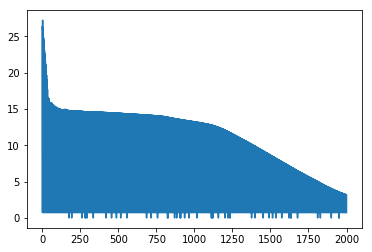

In [116]:
import matplotlib.pyplot as plt 
plt.plot(model.losses[::])
plt.show()

# **References:**

1. Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

2. Yang Song, Alexander G Schwing, Richard S Zemel, and Raquel Urtasun. Training deep neural networks via direct loss minimization. In Proceedings of The 33rd International Conference on Machine Learning, pages 2169–2177, 2016.

In [ ]:
from qutip import *

In [ ]:
num_units=3

In [ ]:
H_M = sum([tensor([qeye(2)  if not (i==n) else sigmax() for i in range(num_units)] )for n in range(num_units) ])

In [ ]:
H_M

In [ ]:
qeye(2)